# 案例：量化交易策略的预测

<div class="alert alert-block alert-success">
本案例研究的目标是使用基于分类的模型，根据短期价格和长期价格预测当前信号是买入还是卖出。基于特征工程，创造出大量的新特征，以期待增加模型的预测能力。最后，我们对于策略进行了回测。
</div>


## 1. 问题定义

我们定义以下问题：
1. 为交易策略预测买入或卖出信号的问题是在分类框架中定义的，其中预测变量的值为 1 表示买入，0 表示卖出。
2. 买入或卖出信号是根据短期价格与长期价格的比较来决定的。



为了进行案例研究，我们从日均交易量最大的比特币交易所之一[Bitstamp](https://www.bitstamp.com) 获取数据。数据可在以下网址找到： <https://www.kaggle.com/mczielinski/bitcoin-historical-data>

## 2. 读取数据集

In [1]:
import pandas as pd
dataset = pd.read_csv('datasets/BitstampData_sample.csv',index_col=0)

### 2.1 描述性统计

In [2]:
# describe data
pd.set_option('float_format', '{:.3f}'.format)
dataset.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,399799.000,383405.000,383405.000,383405.000,383405.000,383405.000,383405.000,383405.000
mean,1557154560.000,7031.337,7035.480,7026.883,7031.060,6.425,47329.645,7031.239
std,6924730.468,3033.128,3035.990,3029.904,3032.790,15.927,133634.941,3033.020
min,1545160620.000,3334.000,3346.120,3322.190,3334.000,0.000,0.006,3335.265
25%,1551157590.000,3891.720,3892.780,3890.610,3891.790,0.361,2214.656,3891.725
50%,1557154560.000,6314.830,6318.520,6308.390,6313.880,1.810,11143.430,6313.278
75%,1563151530.000,10130.580,10135.620,10125.000,10129.340,6.236,40697.549,10130.608
max,1569148500.000,13853.250,13880.000,13830.060,13850.570,862.230,7569437.061,13841.523


## 3. 数据准备

### 3.1 数据清洗

In [3]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


鉴于存在空值，我们需要用最后可用的值填充 NaN，从而清理数据。

In [4]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [5]:
dataset=dataset.drop(columns=['Timestamp'])

### 3.2 交易信号

我们为每一个走势贴上标签：

- 如果信号显示短期价格将比长期价格上涨，则标记为 1；
- 如果信号显示短期价格将比长期价格下跌，则标记为 0。

可以设计为：如果短期移动平均线超过长期移动平均线，则信号为 1.0，否则为 0.0

In [6]:
import numpy as np

# 创建短期简单移动平均线，窗口为短期窗口
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1, center=False).mean()

# 创建长期简单移动平均线，窗口为长期窗口
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1, center=False).mean()

# 创建交易信号
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [7]:
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal
4057367,10000.000,10000.000,9988.720,9999.970,0.132,1319.534,9996.881,10008.898,10002.768,1.000
4057368,9988.700,10000.000,9988.700,10000.000,0.495,4950.563,9997.854,10006.900,10003.147,1.000
4057369,9991.520,10000.000,9991.520,9991.520,0.072,720.087,9999.410,10005.066,10003.384,1.000
4057370,9994.220,10000.000,9986.610,9986.610,0.097,966.287,9995.272,10002.850,10003.484,0.000
4057371,9997.920,9997.920,9984.750,9988.850,17.229,172102.361,9989.339,9999.861,10003.487,0.000


### 3.3 特征工程——构建技术指标

首先，我们要构建一个数据集，其中包含用于预测的预测因子和输出变量。

双币的当前数据包括日期、开盘价、最高价、最低价、收盘价和成交量。利用这些数据，我们可以计算出以下技术指标：

- 移动平均线：移动平均线通过减少价格图表上的 "噪音 "量来显示价格变动的趋势。
- 随机震荡指标 %K 和 %D：随机震荡指标是一种动量指标，将证券的特定收盘价与一定时期内的价格范围进行比较。%K 和 %D 是慢速和快速指标。
- 相对强弱指数（RSI）：这是一种动量指标，用于衡量近期价格变化的幅度，以评估股票或其他资产价格的超买或超卖情况。
- 变化率（ROC）： 这是一种动量震荡指标，用于测量当前价格与过去 N 期价格之间的百分比变化。
- 动量（MOM）：是指证券价格或成交量的加速率，即价格变化的速度。

计算指数移动平均线

In [8]:
def EMA(df, n):
    # 计算指数移动平均线并将结果存储为序列，使用给定的窗口大小 n
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA

# 计算并添加10日指数移动平均线到数据集
dataset['EMA10'] = EMA(dataset, 10)

# 计算并添加30日指数移动平均线到数据集
dataset['EMA30'] = EMA(dataset, 30)

# 计算并添加200日指数移动平均线到数据集
dataset['EMA200'] = EMA(dataset, 200)

计算变动率（Rate of Change）

In [9]:
def ROC(df, n):  
    # 计算价格变动值 M
    M = df.diff(n - 1)  
    # 获取 n 期前的价格 N
    N = df.shift(n - 1)  
    # 计算变动率 ROC，并将结果存储为序列
    ROC = pd.Series(((M / N) * 100), name='ROC_' + str(n))   
    return ROC

# 计算并添加10日变动率到数据集
dataset['ROC10'] = ROC(dataset['Close'], 10)

# 计算并添加30日变动率到数据集
dataset['ROC30'] = ROC(dataset['Close'], 30)

计算价格动量（Price Momentum）

In [10]:
def MOM(df, n):   
    # 计算价格变化值 MOM
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM

# 计算并添加10日价格动量到数据集
dataset['MOM10'] = MOM(dataset['Close'], 10)

# 计算并添加30日价格动量到数据集
dataset['MOM30'] = MOM(dataset['Close'], 30)

计算相对强度指数（Relative Strength Index，RSI）

In [11]:
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) # 第一个值是平均增益的总和
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) # 第一个值是平均损失的总和
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / \
         d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

# 计算并添加10日相对强度指数到数据集
dataset['RSI10'] = RSI(dataset['Close'], 10)

# 计算并添加30日相对强度指数到数据集
dataset['RSI30'] = RSI(dataset['Close'], 30)

# 计算并添加200日相对强度指数到数据集
dataset['RSI200'] = RSI(dataset['Close'], 200)

计算随机振荡指标（Stochastic Oscillator）

In [12]:
# 计算 %K 值
def STOK(close, low, high, n): 
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

# 计算 %D 值
def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

# 计算并添加10日随机振荡指标到数据集
dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)

# 计算并添加30日随机振荡指标到数据集
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)

# 计算并添加200日随机振荡指标到数据集
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

计算移动平均线（Moving Average）

In [13]:
# 计算移动平均线
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA

# 计算并添加21日移动平均线到数据集
dataset['MA21'] = MA(dataset, 10)

# 计算并添加63日移动平均线到数据集
dataset['MA63'] = MA(dataset, 30)

# 计算并添加252日移动平均线到数据集
dataset['MA252'] = MA(dataset, 200)

# 显示数据集的末尾
dataset.tail()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,short_mavg,long_mavg,signal,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
4057367,10000.000,10000.000,9988.720,9999.970,0.132,1319.534,9996.881,10008.898,10002.768,1.000,...,51.416,36.335,36.909,24.848,23.946,45.168,46.651,10008.898,10010.127,10006.229
4057368,9988.700,10000.000,9988.700,10000.000,0.495,4950.563,9997.854,10006.900,10003.147,1.000,...,51.418,36.734,36.492,24.913,24.891,45.185,45.179,10006.900,10009.815,10006.512
4057369,9991.520,10000.000,9991.520,9991.520,0.072,720.087,9999.410,10005.066,10003.384,1.000,...,50.920,9.528,27.532,6.462,18.741,40.200,43.518,10005.066,10009.215,10006.799
4057370,9994.220,10000.000,9986.610,9986.610,0.097,966.287,9995.272,10002.850,10003.484,0.000,...,50.634,0.000,15.421,0.000,10.458,37.313,40.899,10002.850,10008.436,10006.998
4057371,9997.920,9997.920,9984.750,9988.850,17.229,172102.361,9989.339,9999.861,10003.487,0.000,...,50.761,12.721,7.416,8.240,4.901,38.630,38.714,9999.861,10007.729,10007.184


删除不需要用于预测的列

In [14]:
dataset=dataset.drop(['High','Low','Open', 'Volume_(Currency)','short_mavg','long_mavg'], axis=1)

In [15]:
dataset = dataset.dropna(axis=0)

In [16]:
dataset.tail()

,Close,Volume_(BTC),Weighted_Price,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
4057367,9999.970,0.132,9996.881,1.000,10006.670,10008.023,9994.701,-0.200,-0.094,-8.120,...,51.416,36.335,36.909,24.848,23.946,45.168,46.651,10008.898,10010.127,10006.229
4057368,10000.000,0.495,9997.854,1.000,10005.457,10007.506,9994.753,-0.099,-0.095,-19.980,...,51.418,36.734,36.492,24.913,24.891,45.185,45.179,10006.900,10009.815,10006.512
4057369,9991.520,0.072,9999.410,1.000,10002.923,10006.474,9994.721,-0.172,-0.185,-18.340,...,50.920,9.528,27.532,6.462,18.741,40.200,43.518,10005.066,10009.215,10006.799
4057370,9986.610,0.097,9995.272,0.000,9999.957,10005.193,9994.641,-0.321,-0.234,-22.160,...,50.634,0.000,15.421,0.000,10.458,37.313,40.899,10002.850,10008.436,10006.998
4057371,9988.850,17.229,9989.339,0.000,9997.938,10004.138,9994.583,-0.184,-0.173,-29.890,...,50.761,12.721,7.416,8.240,4.901,38.630,38.714,9999.861,10007.729,10007.184


### 3.4 数据可视化

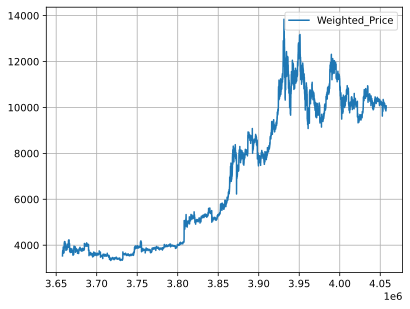

In [46]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') 
dataset[['Weighted_Price']].plot(grid=True)
plt.show()

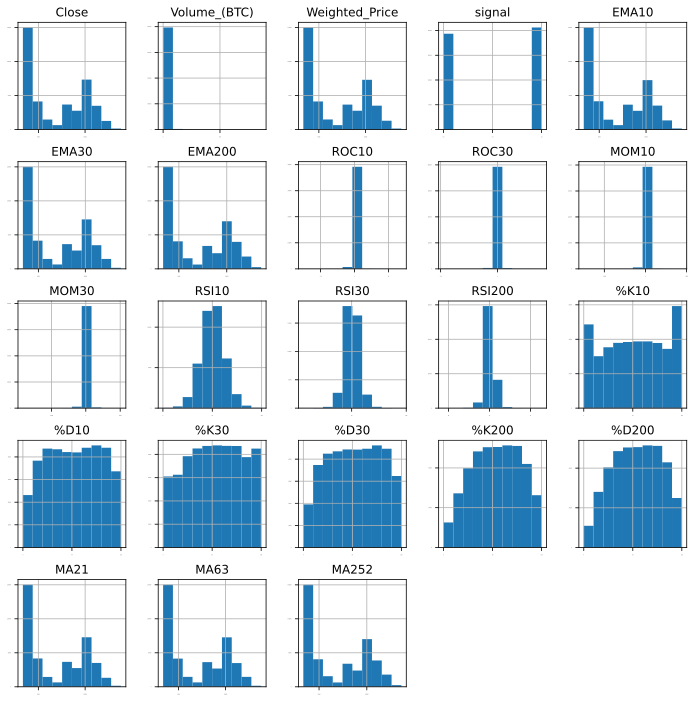

In [47]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

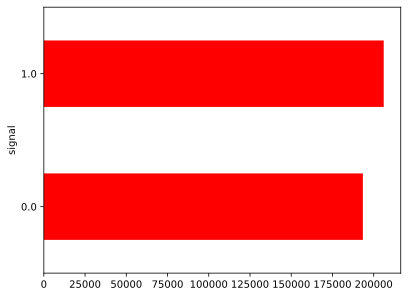

In [48]:
fig = plt.figure()
plot = dataset.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

买入信号的数量多于卖出信号的数量

计算并可视化相关性矩阵

<Axes: title={'center': 'Correlation Matrix'}>

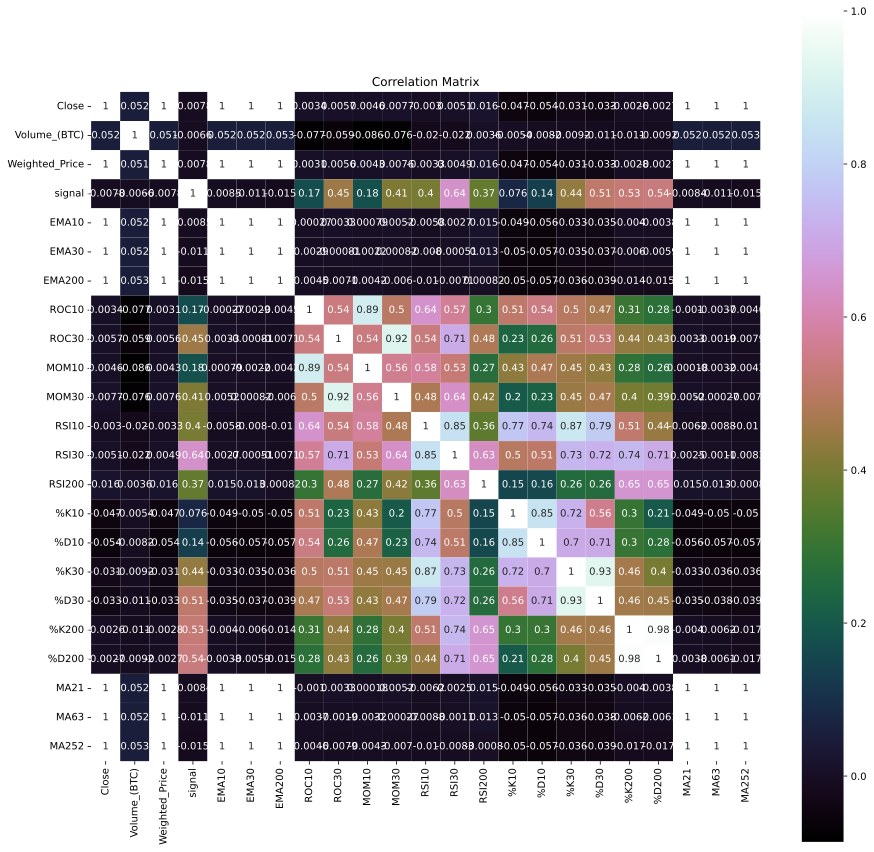

In [49]:
import seaborn as sns
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

## 4. 建模和评估算法

### 4.1 训练集/测试集划分

分割出用于最后验证的数据集

In [50]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

# 提取目标变量 Y
Y = dataset["signal"]

# 提取特征变量 X
X = dataset.loc[:, dataset.columns != 'signal']

# 定义验证集的大小
test_size = 0.2

# 将数据集划分为训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8,random_state=42)

### 4.2 训练集表现

应用决策树分类器模型。决策树是一种基于树形结构的分类算法，通过对特征进行递归划分来进行决策。在这里，`DecisionTreeClassifier`类的实例被创建。

In [51]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=3, splitter='best')

In [52]:
model.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=3)

In [53]:
Y_train_predicted = model.predict(X_train)

In [54]:
accuracy = model.score(X_train, Y_train)

In [55]:
from sklearn import metrics
precision = metrics.precision_score(Y_train, Y_train_predicted)
recall = metrics.recall_score(Y_train, Y_train_predicted)
f1_score = metrics.f1_score(Y_train, Y_train_predicted)

In [56]:
print(accuracy, precision,recall,f1_score)

0.8527827142571085 0.8588997788836977 0.8551233534677243 0.8570074059667112


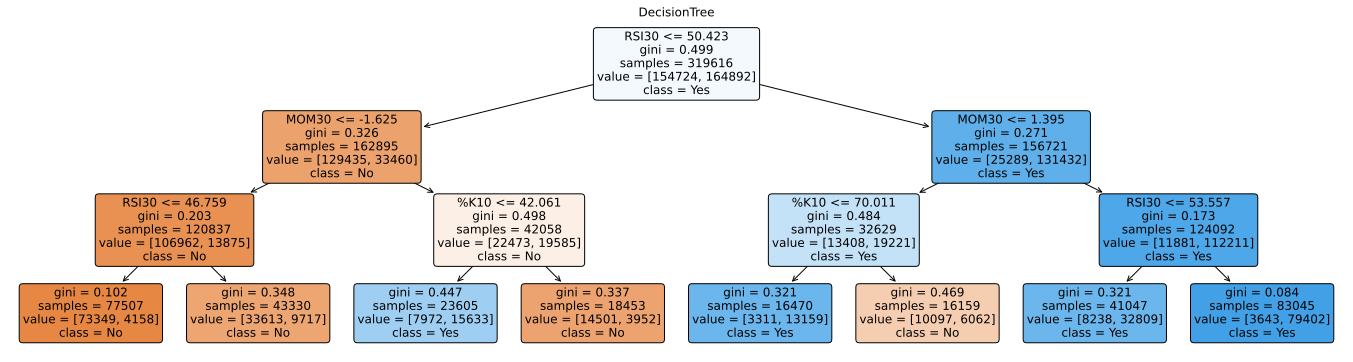

In [57]:
from sklearn.tree import plot_tree
plt.figure(figsize=(24,6))
plot_tree(model,
          max_depth=3,
         class_names=['No', 'Yes'],
         feature_names=X_train.columns.to_list(),
          rounded=True,
          fontsize=12,
         filled=True)
plt.title('DecisionTree') 
plt.show()

### 4.3 测试集表现

In [58]:
Y_test_predicted = model.predict(X_test)

In [59]:
accuracy = model.score(X_test, Y_test)

In [60]:
from sklearn import metrics
precision = metrics.precision_score(Y_test, Y_test_predicted)
recall = metrics.recall_score(Y_test, Y_test_predicted)
f1_score = metrics.f1_score(Y_test, Y_test_predicted)

In [61]:
print(accuracy, precision,recall,f1_score)

0.853551091921657 0.8586509693269442 0.8569833215993785 0.8578163349614834


### 4.4 特征重要性排序

Text(0.5, 0, 'Variable Importance')

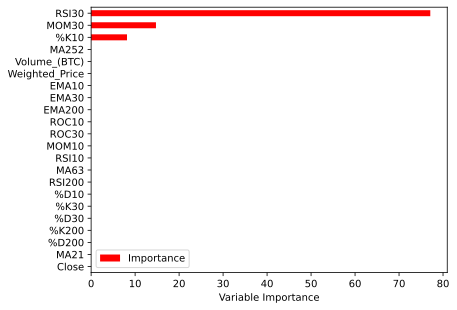

In [62]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

## 5. 策略回测

通过将前一天的持仓与当天的日收益率相乘，创建策略收益率列

In [63]:
backtestdata = pd.DataFrame(index=X_test.index)
backtestdata['signal_pred'] = Y_test_predicted       # 预测信号
backtestdata['signal_actual'] = Y_test               # 实际信号
backtestdata['Market Price'] = X_test['Close']       # 市场价格

考虑到X_test和Y_test是随机排序，这里需要按照序号重新从小打到排序

In [64]:
backtestdata=backtestdata.sort_index()

In [65]:
backtestdata['Market Returns'] = backtestdata['Market Price'].pct_change()   # 市场收益率

In [66]:
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)  # 实际收益率
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)   # 策略收益率
backtestdata.head()

,signal_pred,signal_actual,Market Price,Market Returns,Actual Returns,Strategy Returns
3657776,0.000,0.000,3537.370,NaN,NaN,NaN
3657781,1.000,1.000,3540.420,0.001,0.000,0.000
3657785,1.000,1.000,3540.420,0.000,0.000,0.000
3657798,1.000,1.000,3554.200,0.004,0.004,0.004
3657800,1.000,1.000,3555.500,0.000,0.000,0.000


绘制策略收益率和实际收益率的累积直方图

array([[<Axes: title={'center': 'Strategy Returns'}>,
        <Axes: title={'center': 'Actual Returns'}>]], dtype=object)

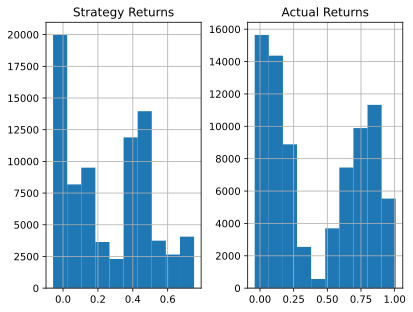

In [67]:
backtestdata = backtestdata.dropna()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()

绘制策略收益率和实际收益率的累积曲线图

<Axes: >

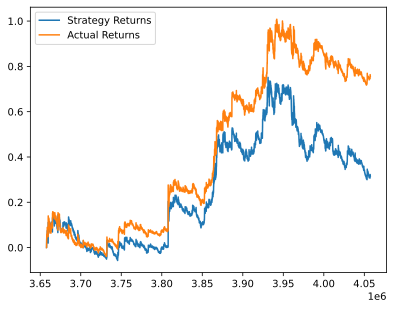

In [68]:
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()

## 结论

我们展示了使用特征工程的效率，它可以创建与价格变动趋势和动量相关的直观特征，并提高模型的预测能力。最后，我们演示了回溯测试框架，该框架允许我们使用历史数据模拟交易策略，以生成结果，并在投入任何实际资金之前分析风险和盈利能力。